## Run MCMC inference using GP model

In [1]:
import random
import time

import tikzplotlib
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro.distributions as npdist
import numpyro
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
import pickle

import jax.config as config
config.update("jax_enable_x64", True)

from priorCVAE.priors import SquaredExponential, Matern12, Matern52
from experiments.zimbabwe_utility import read_data

numpyro.set_host_device_count(4)

import yaml
import flax.linen as nn
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params

In [2]:
data_path = "../../data/zimbabwe/zwe2016phia.geojson"
num_warmup = 4000
num_samples = 20000
num_chains = 2
kernel = Matern52()

## Load Data

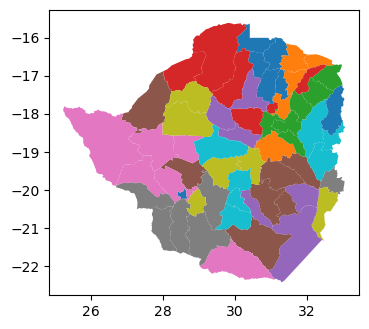

In [3]:
data = gpd.read_file(data_path)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
data.plot(column='area_id', ax=ax, legend=False)

plt.show()

In [4]:
x, data_centroid = read_data(data_path, normalize=True)

/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe_utility.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_frame["centroid"] = data_frame["geometry"].centroid
/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe_utility.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = data_frame["geometry"].centroid


(-0.05888487450251876,
 1.1035178484238617,
 -0.058928571428571455,
 1.0589285714285714)

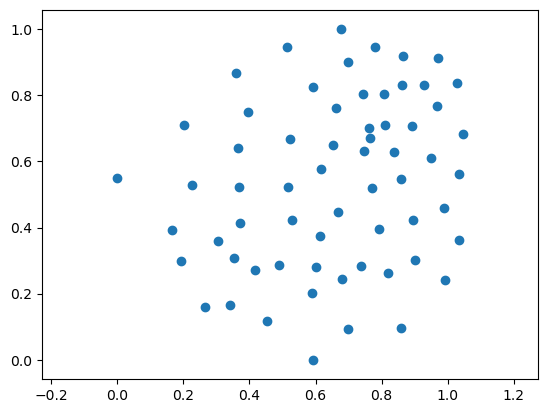

In [5]:
plt.scatter(x[:, 1], x[:, 0])
plt.axis("equal")

In [6]:
## Adding estimate data
data_centroid["estimate"] = data["estimate"]

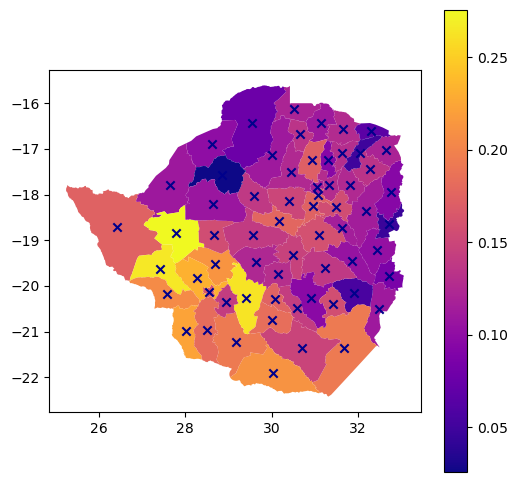

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
data_centroid.plot(column='estimate', ax=ax, legend=True, cmap='plasma')
data_centroid["centroid"].plot(ax=ax, color="DarkBlue", marker="x")
plt.show()

In [8]:
def model_gp(x, n_obs=None, kernel=kernel, lengthscale=None, y=None):
    if lengthscale == None: 
        lengthscale = numpyro.sample("lengthscale", npdist.Uniform(0, 1.0)) 
        
    kernel.lengthscale = lengthscale
    k = kernel(x, x)
    
    kernel_var = numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
    N = x.shape[0]
    re_std = numpyro.sample('re_std', npdist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=k))
    re = numpyro.deterministic('re', kernel_var * re_std)
    
    # calculated here as it is required later for plotting purposes
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(re))
    
    # Logits transformation happens inside the numpyro distribution.
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=re), obs=y)

## Observations

In [9]:
data['y'] = round(data['y']).astype(int)
data['n_obs'] = round(data['n_obs']).astype(int)

## GP Prior

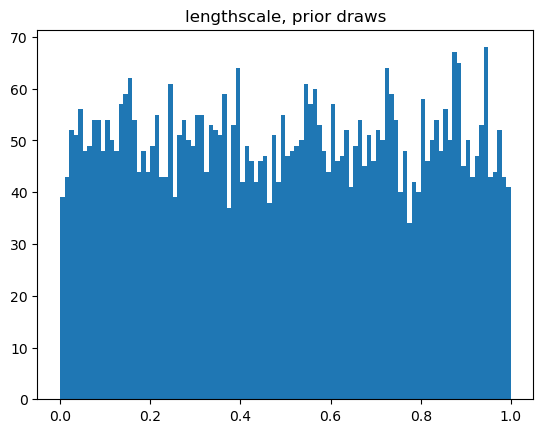

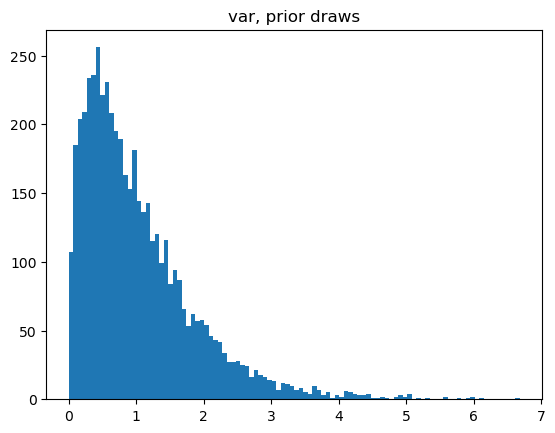

In [10]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))
gp_predictive = Predictive(model_gp, num_samples=5000)
gp_preds = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs))

ls_prior_draws = gp_preds['lengthscale']
plt.hist(ls_prior_draws, bins=100)
plt.title('lengthscale, prior draws')
plt.show()

kernel_var_prior = gp_preds['variance']
plt.hist(kernel_var_prior, bins=100)
plt.title('var, prior draws')
plt.show()

## MCMC Inference using GP Prior

In [11]:
rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(random.randint(0, 999999)))

# inference
start = time.time()
mcmc_gp_model = NUTS(model_gp)
mcmc_gp = MCMC(mcmc_gp_model, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc_gp.run(rng_key, x=x, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y), kernel=Matern52())
t_elapsed = time.time() - start

  0%|          | 0/24000 [00:00<?, ?it/s]

  0%|          | 0/24000 [00:00<?, ?it/s]

In [12]:
#fname = 'mcmc_fits/zimbabwe_gp_mcmc_Matern12_Uniform.pkl'
#with open(fname, 'wb') as f:
#    pickle.dump(mcmc_gp, f)

In [13]:
mcmc_gp.print_summary(exclude_deterministic=True)
mcmc_gp_samples = mcmc_gp.get_samples()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.71      0.13      0.72      0.48      0.91    403.56      1.03
    re_std[0]     -1.07      0.27     -1.05     -1.50     -0.62    264.05      1.01
    re_std[1]     -1.28      0.33     -1.25     -1.81     -0.75    262.11      1.01
    re_std[2]     -1.29      0.33     -1.26     -1.81     -0.75    261.47      1.01
    re_std[3]     -1.47      0.38     -1.44     -2.07     -0.86    264.44      1.01
    re_std[4]     -1.60      0.41     -1.57     -2.26     -0.95    271.76      1.01
    re_std[5]     -1.44      0.37     -1.41     -2.03     -0.85    273.10      1.01
    re_std[6]     -1.47      0.38     -1.44     -2.06     -0.85    263.88      1.01
    re_std[7]     -1.57      0.40     -1.54     -2.21     -0.93    264.80      1.01
    re_std[8]     -1.60      0.41     -1.57     -2.24     -0.94    269.85      1.01
    re_std[9]     -1.57      0.40     -1.54     -2.20     -0.92    274.04  

In [14]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc_gp.get_samples(group_by_chain=True))
r = jnp.mean(ss['re']['n_eff'])
print("Average ESS for all REs : " + str(round(r)))


MCMC elapsed time: 1793 s
Average ESS for all REs : 20244


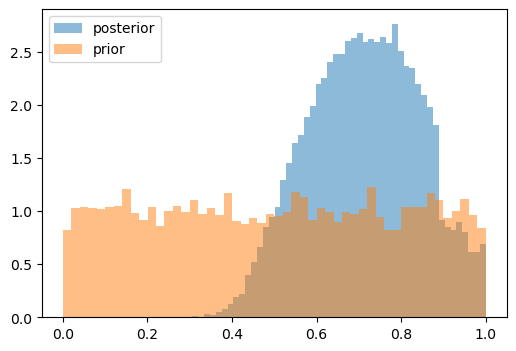

In [15]:
c_samps_gp = mcmc_gp_samples['lengthscale']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(c_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('lengthscale, prior and posterior')
plt.legend()
#plt.xlim([0, 3])

tikzplotlib.save(r"lengthscale.tex",
                 figurewidth='\\figurewidth', figureheight='\\figureheight',
                 figure=fig)

plt.show()

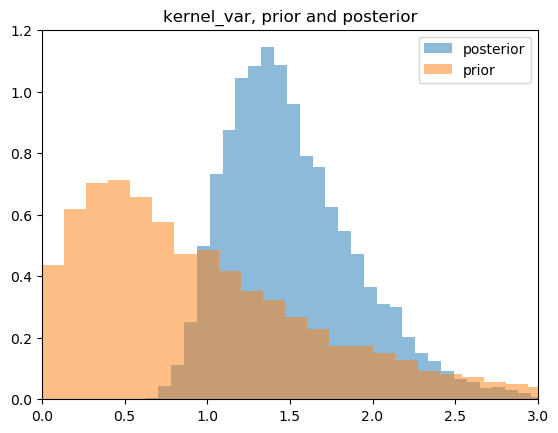

In [16]:
var_samps_gp = mcmc_gp_samples['variance']
plt.hist(var_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, label = 'prior', bins=50, alpha=0.5)
plt.title('kernel_var, prior and posterior')
plt.legend()
plt.xlim(0,3)

# tikzplotlib.save(r"variance.tex",
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 figure=fig)

plt.show()

(24.8460406, 33.4588074, -22.7626307, -15.268733300000001)

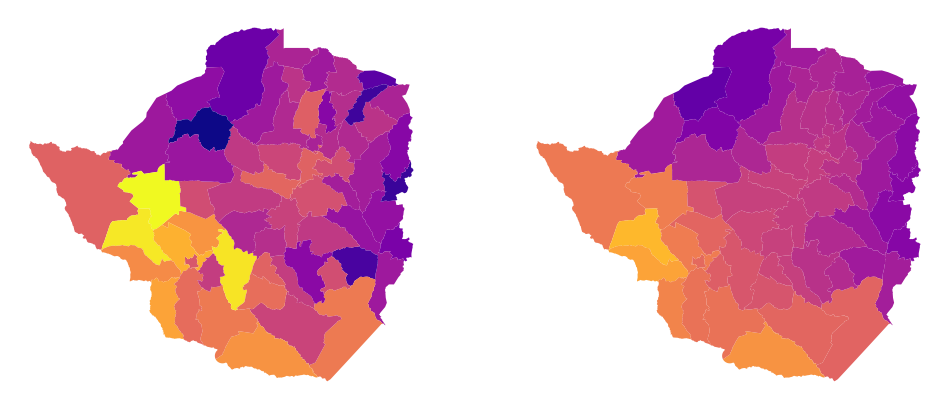

In [17]:
# posterior predictive
posterior_predictive_gp = Predictive(model_gp, mcmc_gp_samples)(jax.random.PRNGKey(random.randint(0, 9999)), 
                                                                         x=x, 
                                                                         n_obs = jnp.array(data.n_obs))


theta_samps_gp = posterior_predictive_gp['theta']
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = jnp.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = jnp.quantile(theta_samps_gp, 0.75, axis=0)

data['theta_gp'] = theta_mean_gp

theta_observed = jnp.array(data['estimate'])
theta_estimated_gp = jnp.array(data['theta_gp'])

_max = np.max([theta_observed, theta_estimated_gp])
_min = np.min([theta_observed, theta_estimated_gp])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
data.plot(column="estimate", ax=ax[0], cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_gp", ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)

ax[0].axis("off")
ax[1].axis("off")

In [18]:
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

#plt.axis("off")
#plt.tight_layout()
#plt.savefig("estimate.pdf")
#plt.show()

In [19]:
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#data.plot(column="theta_gp", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

#plt.axis("off")
#plt.tight_layout()
#plt.savefig("gp_inference.pdf")
#plt.show()

## Define model - PriorCVAE

In [18]:
output_dir = "../outputs/hqajt3ro"
data_path = "../data/zwe2016phia.geojson"
n_samples = 5000

In [19]:
import os
cfg_path = os.path.join(output_dir, ".hydra", "config.yaml")
with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

conditional = cfg_data["conditional"]
latent_dim = cfg_data["latent_dim"]
normalize = cfg_data["normalize"]
dec_activation_fn = cfg_data["dec_activation"]["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/hqajt3ro/.hydra/config.yaml'

In [29]:
trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

In [30]:
def model_cvae(latent_dim, n_obs=None, lengthscale=None, y=None):
    
    # fixed effects
    #b0 = numpyro.sample('b0', npdist.Normal(0, 1))

    if lengthscale == None:
        #lengthscale = numpyro.sample("lengthscale", npdist.Gamma(2,4)) 
        lengthscale = numpyro.sample("lengthscale", npdist.Uniform(0,1)) 

    c = jnp.array([lengthscale])

    kernel_var = numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
#     kernel_var = 0.77
    
    z = numpyro.sample("z", npdist.Normal(jnp.zeros(latent_dim), jnp.ones(latent_dim)))
    z = jnp.concatenate([z, c]) 
    f = numpyro.deterministic('f', decoder.apply({'params': trained_decoder_params}, z))
     
    re = numpyro.deterministic('re', kernel_var * f)
    
#     theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))
    
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=re), obs=y)

## Inference PriorCVAE

In [31]:
fname = 'zimbabwe_cvae_mcmc_Matern12.pkl'

rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(random.randint(0, 999999)))

# inference
start = time.time()
kernel = NUTS(model_cvae)
mcmc_cvae = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc_cvae.run(rng_key, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y))
t_elapsed = time.time() - start

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

In [32]:
mcmc_cvae.print_summary(exclude_deterministic=True)


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.84      0.13      0.87      0.66      1.00  16773.48      1.00
     variance      1.13      0.24      1.09      0.76      1.49   6330.29      1.00
         z[0]      0.03      0.99      0.04     -1.64      1.62  30129.01      1.00
         z[1]     -0.07      1.00     -0.07     -1.64      1.65  32032.81      1.00
         z[2]     -0.01      1.00     -0.01     -1.58      1.68  30672.41      1.00
         z[3]      0.08      0.99      0.08     -1.55      1.68  31509.58      1.00
         z[4]     -0.01      1.00     -0.01     -1.61      1.65  28360.23      1.00
         z[5]      0.01      0.99      0.02     -1.62      1.66  31492.86      1.00
         z[6]      0.08      1.00      0.07     -1.52      1.74  31658.20      1.00
         z[7]      0.02      1.00      0.02     -1.66      1.63  29729.73      1.00
         z[8]     -0.02      0.97     -0.02     -1.57      1.59  30016.66  

In [33]:
mcmc_cvae_samples = mcmc_cvae.get_samples()

In [34]:
mcmc_cvae.print_summary(exclude_deterministic=False)


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
         f[0]     -1.43      0.29     -1.41     -1.91     -0.97   6308.01      1.00
         f[1]     -1.65      0.33     -1.63     -2.19     -1.10   6230.72      1.00
         f[2]     -1.67      0.34     -1.65     -2.22     -1.13   6189.89      1.00
         f[3]     -2.00      0.40     -1.98     -2.65     -1.35   6230.90      1.00
         f[4]     -2.01      0.40     -1.99     -2.68     -1.36   6308.10      1.00
         f[5]     -1.93      0.39     -1.91     -2.57     -1.30   6377.60      1.00
         f[6]     -1.97      0.40     -1.94     -2.59     -1.30   6184.33      1.00
         f[7]     -2.04      0.41     -2.02     -2.69     -1.36   6232.46      1.00
         f[8]     -1.95      0.40     -1.93     -2.58     -1.29   6269.39      1.00
         f[9]     -2.00      0.40     -1.97     -2.66     -1.34   6202.08      1.00
        f[10]     -1.81      0.37     -1.78     -2.38     -1.19   6177.08  

In [35]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc_cvae.get_samples(group_by_chain=True))
r = jnp.mean(ss['re']['n_eff'])
print("Average ESS for all REs : " + str(round(r)))


MCMC elapsed time: 6 s
Average ESS for all REs : 26345


<Figure size 640x480 with 0 Axes>

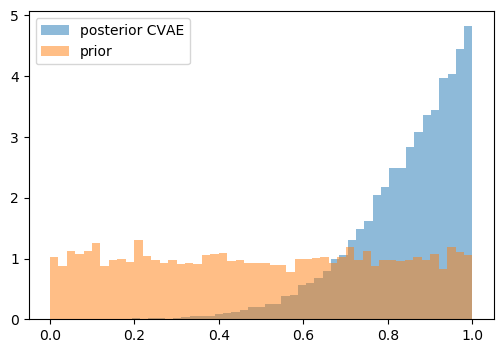

In [36]:
c_samps_cvae = mcmc_cvae_samples['lengthscale']

plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(c_samps_cvae, density=True, label = 'posterior CVAE', bins=50, alpha=0.5)
# plt.hist(c_samps_gp, density=True, label = 'posterior GP', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('lengthscale, prior and posterior')
plt.legend()
#plt.xlim([0, 3])

tikzplotlib.save(r"lengthscale.tex",
                 figurewidth='\\figurewidth', figureheight='\\figureheight',
                 figure=fig)

plt.show()

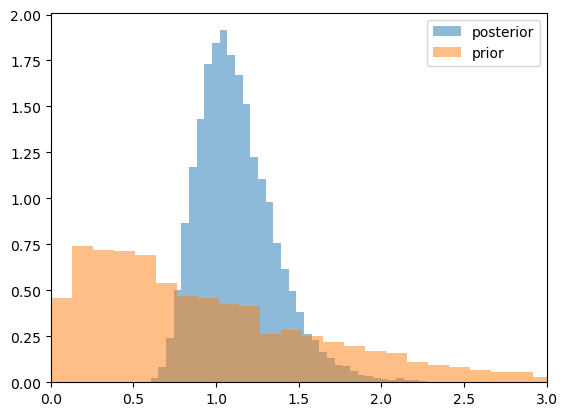

In [37]:
var_samps_cvae = mcmc_cvae_samples['variance']
plt.hist(var_samps_cvae, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('kernel_var, prior and posterior')
plt.legend()
plt.xlim(0,3)

# tikzplotlib.save(r"variance.tex",
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 figure=fig)

plt.show()

(24.8460406, 33.4588074, -22.7626307, -15.268733300000001)

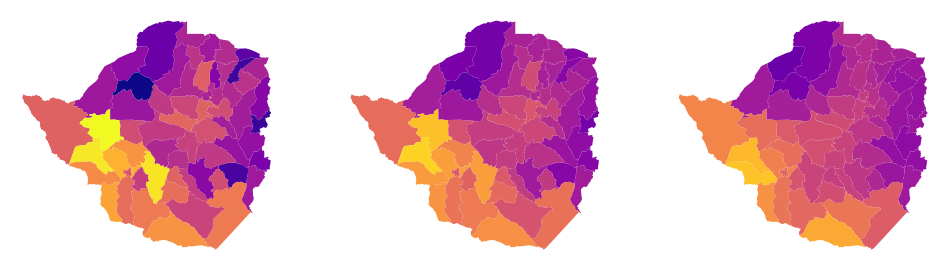

In [38]:
# posterior predictive
posterior_predictive_cvae = Predictive(model_cvae, mcmc_cvae_samples)(jax.random.PRNGKey(random.randint(0, 9999)), 
                                                                         latent_dim=latent_dim, 
                                                                         n_obs = jnp.array(data.n_obs))


theta_samps_cvae = posterior_predictive_cvae['theta']
theta_mean_cvae = theta_samps_cvae.mean(axis=0)
#bci_cvae_25 = jnp.quantile(theta_samps_cvae, 0.25, axis=0)
#bci_cvae_75 = jnp.quantile(theta_samps_cvae, 0.75, axis=0)

data['theta_cvae'] = theta_mean_cvae

theta_observed = jnp.array(data['estimate'])
theta_estimated_cvae = jnp.array(data['theta_cvae'])
theta_estimated_gp = jnp.array(data['theta_gp'])

_max = np.max([theta_observed, theta_estimated_gp, theta_estimated_cvae])
_min = np.min([theta_observed, theta_estimated_gp, theta_estimated_cvae])

fig, ax = plt.subplots(1, 3, figsize=(12,6))
data.plot(column="estimate",   ax=ax[0], cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_gp",   ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_cvae", ax=ax[2], cmap='plasma', vmin=_min, vmax =_max)

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

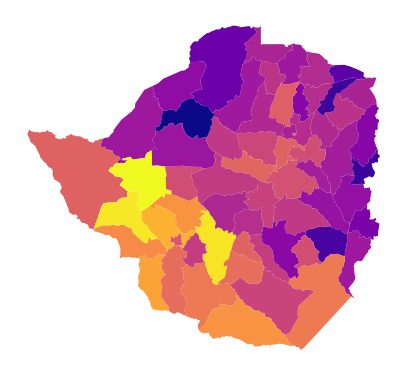

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)
# data.plot(column="theta_gp",   ax=ax, cmap='plasma', vmin=_min, vmax =_max)
# data.plot(column="theta_cvae", ax=ax[2], cmap='plasma', vmin=_min, vmax =_max)

plt.axis("off")

plt.savefig("estimate.pdf", dpi=300)

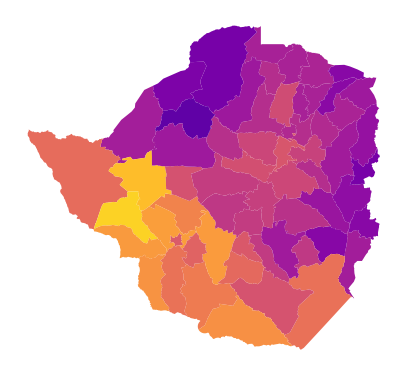

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_gp",   ax=ax, cmap='plasma', vmin=_min, vmax =_max)
# data.plot(column="theta_cvae", ax=ax[2], cmap='plasma', vmin=_min, vmax =_max)

plt.axis("off")

plt.savefig("gp_inference.pdf", dpi=300)

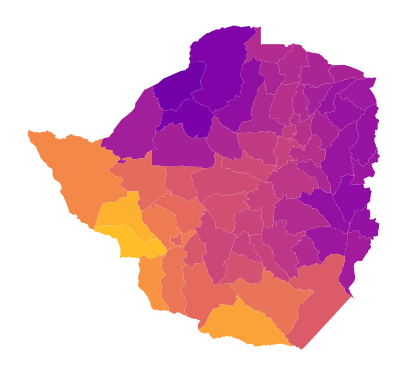

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)
# data.plot(column="theta_gp",   ax=ax, cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_cvae", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

plt.axis("off")

plt.savefig("our_inference.pdf", dpi=300)

Text(0, 0.5, 'cvae')

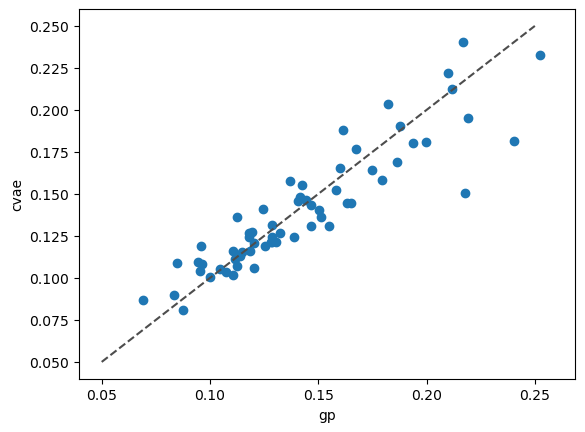

In [31]:
plt.scatter(theta_estimated_gp, theta_estimated_cvae)
plt.plot([0.05, 0.25], [0.05, 0.25], ls="--", c=".3")
plt.xlabel('gp')
plt.ylabel('cvae')

Text(0, 0.5, 'cvae')

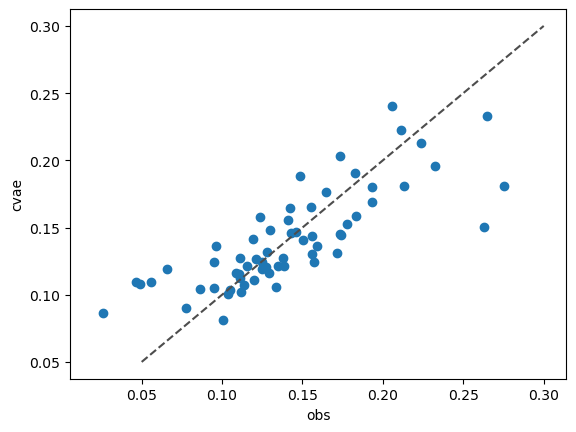

In [32]:
plt.scatter(theta_observed, theta_estimated_cvae)
plt.plot([0.05, 0.3], [0.05, 0.3], ls="--", c=".3")
plt.xlabel('obs')
plt.ylabel('cvae')

Text(0, 0.5, 'gp')

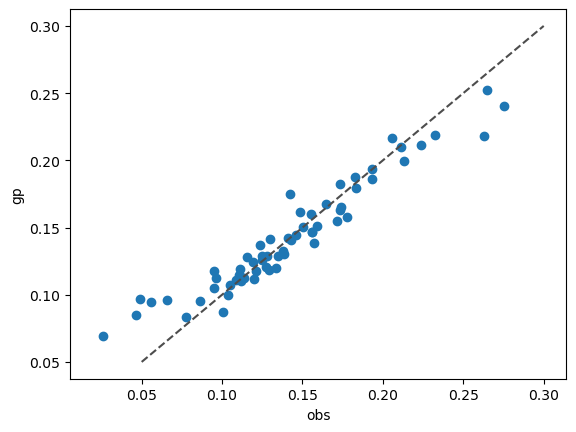

In [33]:
plt.scatter(theta_observed, theta_estimated_gp)
plt.plot([0.05, 0.3], [0.05, 0.3], ls="--", c=".3")
plt.xlabel('obs')
plt.ylabel('gp')

## Plot PriorCVAE priors

In [34]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))

cvae_predictive = Predictive(model_cvae, num_samples=100)
cvae_preds_map  = cvae_predictive(rng_key_, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), 
                                  lengthscale = 0.1)

gp_predictive = Predictive(model_gp, num_samples=100)
gp_preds_map  = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs), lengthscale = 0.1)


In [35]:
cvae_preds_map_f = cvae_preds_map['f']
gp_preds_map_f   = gp_preds_map['re_std']

In [36]:
_max = np.max([cvae_preds_map_f, gp_preds_map_f])
_min = np.min([cvae_preds_map_f, gp_preds_map_f])

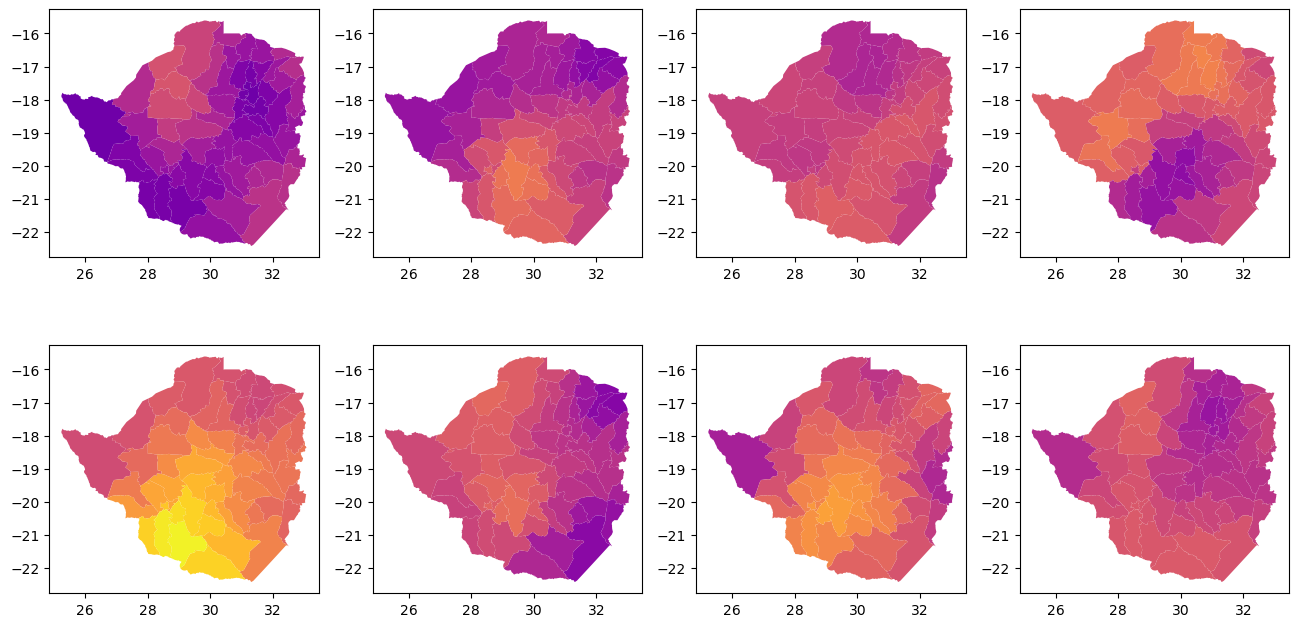

In [40]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    rows = int(i//4)
    cols = int(i%4)
    
    data['f' + str(i)] = cvae_preds_map_f[i, :]

    data.plot(column='f' + str(i),   ax=axs[rows][cols], cmap='plasma', vmin=_min, vmax =_max)

    

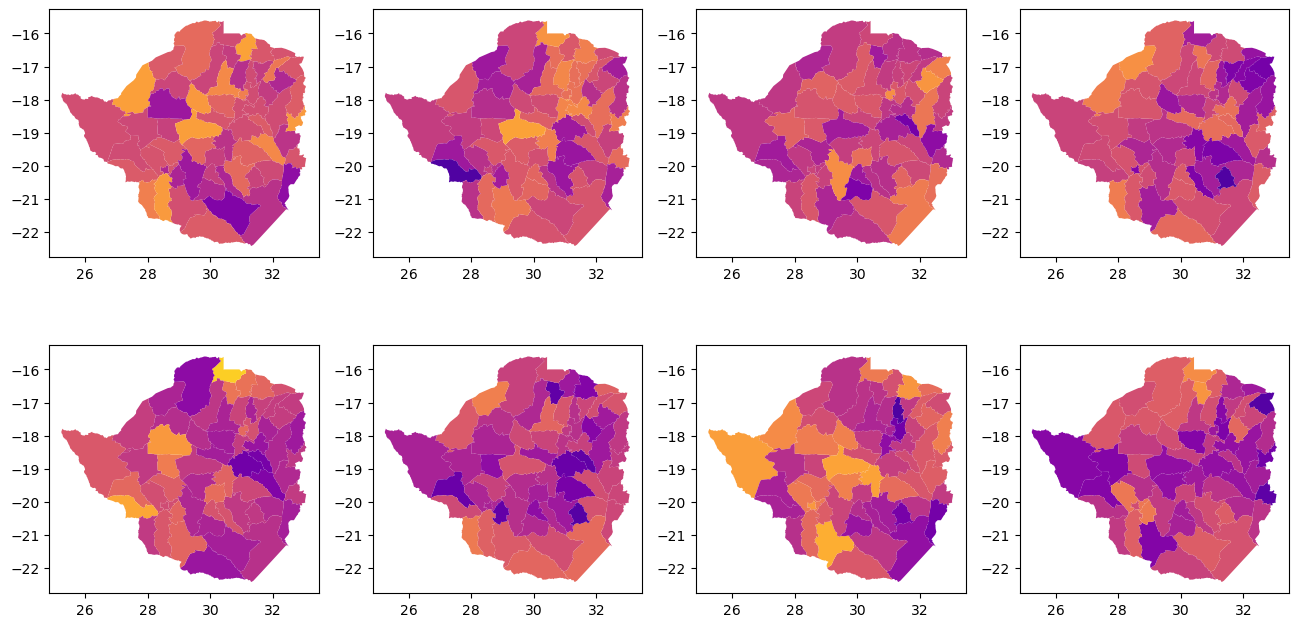

In [41]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    rows = int(i//4)
    cols = int(i%4)
    
    data['gp' + str(i)] = gp_preds_map_f[i, :]

    data.plot(column='gp' + str(i),   ax=axs[rows][cols], cmap='plasma', vmin=_min, vmax =_max)

## Plot ls

(0, 1.0)

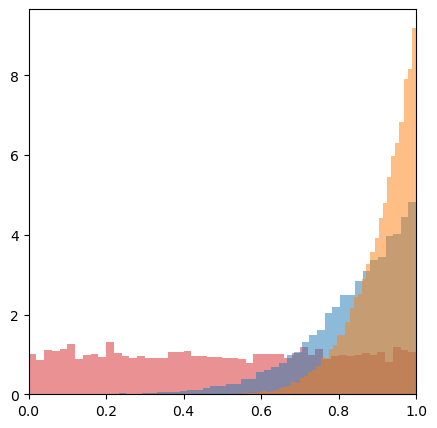

In [39]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

plt.hist(ls_prior_draws, density=True, label = 'Prior', bins=50, alpha=0.5, color="tab:red")
plt.hist(c_samps_cvae, density=True, label = 'PriorCVAE', bins=50, alpha=0.5, color="tab:blue")
plt.hist(c_samps_gp, density=True, label = 'GP', bins=50, alpha=0.5, color="tab:orange")

# plt.legend()
plt.xlim(0, 1.)

# tikzplotlib.save(r"lengthscale.tex",
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 figure=fig)


(0, 3)

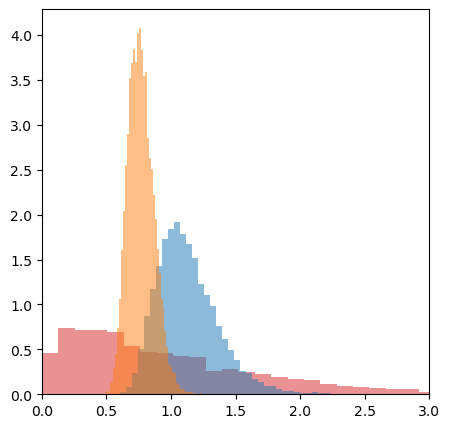

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

plt.hist(kernel_var_prior, density=True, label = 'Prior', bins=50, alpha=0.5, color="tab:red")
plt.hist(mcmc_cvae_samples['variance'], density=True, label = 'PriorCVAE', bins=50, alpha=0.5, color="tab:blue")
plt.hist(var_samps_gp, density=True, label = 'GP', bins=50, alpha=0.5, color="tab:orange")

# plt.legend()
plt.xlim(0, 3)

# tikzplotlib.save(r"variance.tex",
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 figure=fig)


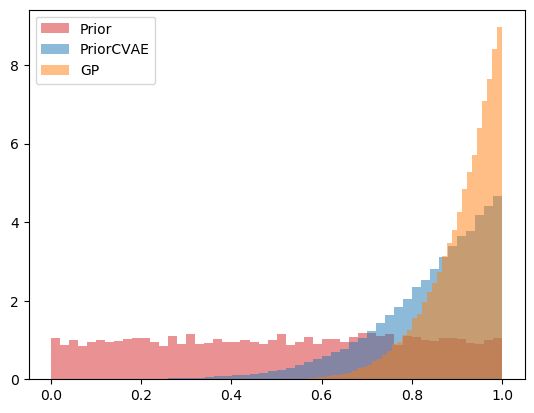

In [51]:
# plt.hist(ls_prior_draws, density=True, label = 'Prior', bins=50, alpha=0.5, color="tab:red")
# plt.hist(c_samps_cvae, density=True, label = 'PriorCVAE', bins=50, alpha=0.5, color="tab:blue")
# plt.hist(c_samps_gp, density=True, label = 'GP', bins=50, alpha=0.5, color="tab:orange")

# plt.legend()
# # plt.xlim(0, 1.)

# # tikzplotlib.save(r"variance.tex",
# #                 figurewidth='\\figurewidth', figureheight='\\figureheight',
# #                 figure=fig)


In [53]:
import scipy

In [54]:
x_min = min((jnp.min(c_samps_gp), jnp.min(c_samps_cvae)))
x_max = max((jnp.max(c_samps_gp), jnp.max(c_samps_cvae)))

In [55]:
x_min, x_max

(Array(0.00062268, dtype=float64), Array(0.99999873, dtype=float64))

(0, 1)

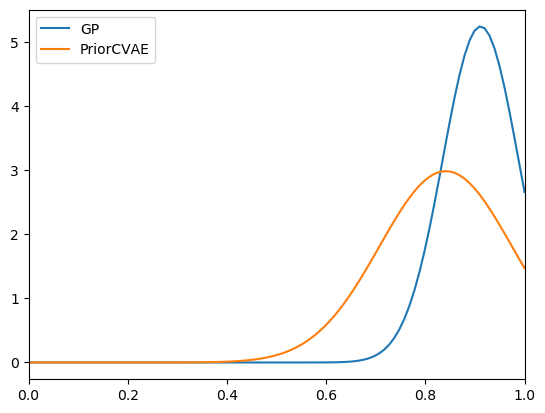

In [56]:
x_tmp = jnp.linspace(x_min, x_max, 100)

gp_mean = jnp.mean(c_samps_gp)
gp_std = jnp.std(c_samps_gp)

cvae_mean = jnp.mean(c_samps_cvae)
cvae_std = jnp.std(c_samps_cvae)

plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, gp_mean, gp_std), label='GP')
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, cvae_mean, cvae_std), label='PriorCVAE')
# plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, gp_mean, gp_std), label='GP', alpha=0.5)

# plt.hist(c_samps_cvae, density=True, label = 'CVAE', bins=50, alpha=0.5)
# plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.hist(c_samps_gp, density=True)

plt.legend()
plt.xlim(0, 1)